In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../src/')
import dataset_prep

Import de la base de données

In [2]:
selected_columns = [
"nb_packets_sent",
"distance",
"distRealSR1",
"pos_y_rec_f",
"pos_y_rec",
"pos_x_rec_f",
"pos_x_rec",
"pos_x_send",
"pos_y_send",
"spd_x_send",
"spd_y_send",
"sendTime",
"receiver",
"sender",
"label"
]

In [3]:
df = dataset_prep.import_dataset('../data/DoS_0709_new_columns.csv', selected_columns)

Nombre de lignes avant nettoyage :  4753433
Nombre de lignes après nettoyage :  4709293


Analyse et vérification des données

In [4]:
senders = np.unique(df["sender"].values)
senders

array([    9,    15,    21, ..., 24399, 24405, 24411], dtype=int64)

In [5]:
print(len(senders))

4067


In [6]:
df.loc[df['sender'] == senders[0]].sort_values("sendTime")

,sendTime,sender,receiver,pos_x_send,pos_y_send,spd_x_send,spd_y_send,label,pos_x_rec,pos_y_rec,pos_x_rec_f,pos_y_rec_f,nb_packets_sent,distRealSR1,distance
4,25212.602877,9,45,257.604242,141.917136,-2.409908,14.316189,0,265.540271,46.207434,268.539855,49.801087,96,7.936029,96.038156
5,25213.602877,9,45,255.242943,156.206787,-2.566640,14.210027,0,268.539855,49.801087,268.050977,55.331302,96,13.296912,107.233302
6,25214.602878,9,45,252.857751,170.495740,-2.342829,14.254332,0,268.050977,55.331302,270.113953,63.318293,96,15.193227,116.162309
7,25215.602879,9,45,250.525544,184.832952,-2.352874,14.315002,0,270.113953,63.318293,268.836896,72.915064,96,19.588409,123.083379
8,25216.602880,9,45,248.511212,199.166902,-2.079440,14.360857,0,268.836896,72.915064,267.267270,84.617270,96,20.325683,127.877519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,25291.602880,9,225,134.821280,1024.506204,-0.602227,8.137469,0,138.085770,1102.386398,138.801402,1096.647173,96,3.264490,77.948582
65,25291.602880,9,147,134.821280,1024.506204,-0.602227,8.137469,0,147.593919,898.797866,147.021568,894.975244,96,12.772639,126.355556
91,25292.602869,9,219,134.539820,1030.197090,-0.270067,3.653434,0,142.457918,1043.790636,143.221108,1033.675922,96,7.918098,15.731521
95,25292.602869,9,225,134.539820,1030.197090,-0.270067,3.653434,0,138.801402,1096.647173,139.551488,1089.075886,96,4.261582,66.586594


In [7]:
# Copie de la bdd pour récuperer les colonnes sans impacter la vraie base de données

data_copy = df.copy()
data_copy = data_copy.drop(["label"], axis=1)

columns = data_copy.columns

Amélioration à faire :

Séléctionner seulement les sender avec value_counts > 20

Séparation de la base de données : diviser pour régner

In [8]:
# /!\ attention à bien utiliser la base de données rangée par sender pour limiter la perte de données
# Indice égal à 0, 1 ou 2
# Célia = 0
# Chléo = 1
# Thomas = 2

def split_data_in_3(df, indice):
    # Division de la bdd en 3
    split_data = np.array_split(df,3)

    # Division en plusieurs sous-bdd pour diminuer le temps de calcul par exécution
    #divided_data = np.array_split(split_data[indice],50)

    return split_data

/!\ à bien changer l'indice !!

In [16]:
divided_dataframes = split_data_in_3(df.sort_values("sender"),0)

In [17]:
len(divided_dataframes)

3

In [ ]:
sequence = (df.loc[df['sender'] == senders[0]].sort_values("sendTime"))[0:20]
sequence.values.tolist()

In [22]:
df.loc[df['receiver'] == senders[7]]['label'].shape[0]

202

In [26]:
label = df.loc[df['sender'] == senders[0]]['label'].tolist()[0]
label

0

Création des séquences

In [23]:
def sequence_creation(df):
    senders_sequences = []
    senders_label = []
    for sender in senders:
        sender_data_sorted = df.loc[df['sender'] == sender].sort_values("sendTime")
        sender_data_sorted = sender_data_sorted.drop(["label","sender"], axis=1)
        sequence_array = []

        length = sender_data_sorted.shape[0]
        slide = 10
        start = 0
        end = 20

        # On récupère la valeur du label pour ce sender
        label = df.loc[df['sender'] == sender]['label'].tolist()[0]
        if (length > 20):
            senders_label.append(label)

        # On vérifie qu'il est possible de faire une séquence de taille 20
        while length > 20:
            # Extraction par tranche de 20 avec une inter de 10
            sequence = sender_data_sorted[start:end]

            # Labels correspondant
            #labels =  pd.Series.tolist(sequence["label"])

            # On transforme les 13 en 1, cette formule marche toujours si on met d'autres types d'attaques
            #labels[:] = [x if x == 0 else 1 for x in labels]

            # Attribution des tableaux numpy
            sequence_array.append(np.array(sequence.values.tolist()))
            #label_array.append(labels)

            # Mise à jour des variables
            start += slide
            end += slide
            length -= 10
        
        if len(sequence_array)>0:
            senders_sequences.append(np.array(sequence_array,dtype=object))

    
    return senders_sequences, senders_label

In [ ]:
for sender in senders:
    # Données d'un seul sender rangée en fonction de l'heure d'envoi
    sender_data_sorted = df.loc[df['sender'] == sender].sort_values("sendTime")
    # On récupère la valeur du label pour ce sender
    print(sender_data_sorted['label'].tolist()[0])

In [9]:
def flat_sequence_creation(df):
    senders_sequences = []
    senders_label = []

    for sender in senders:
        # Données d'un seul sender rangée en fonction de l'heure d'envoi
        sender_data_sorted = df.loc[df['sender'] == sender].sort_values("sendTime")
        # On récupère la valeur du label pour ce sender
        label = sender_data_sorted['label'].tolist()[0]
        #On supprime les colonnes label et sender
        sender_data_sorted = sender_data_sorted.drop(["label","sender"], axis=1)
        
        #sequence_array = []

        length = sender_data_sorted.shape[0]
        slide = 10
        start = 0
        end = 20

        # On vérifie qu'il est possible de faire une séquence de taille 20
        while length > 20:
            # Extraction par tranche de 20 avec une inter de 10
            sequence = sender_data_sorted[start:end]

            # Labels correspondant
            #labels =  pd.Series.tolist(sequence["label"])

            # On transforme les 13 en 1, cette formule marche toujours si on met d'autres types d'attaques
            #labels[:] = [x if x == 0 else 1 for x in labels]

            # Attribution des tableaux numpy
            senders_sequences.append(np.array(sequence.values.tolist(), dtype=np.float32))
            senders_label.append(label)

            # Mise à jour des variables
            start += slide
            end += slide
            length -= 10

    return senders_sequences, senders_label

/!\ à bien changer l'indice !!

In [10]:
sorted_dataset = df.sort_values("sender")

In [11]:
sequence_test, label_test = flat_sequence_creation(sorted_dataset)

Vérification des séquences obtenues

In [66]:
len(sequence_test)

464647

Initialisation des données

In [12]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras import layers, applications, utils, models, optimizers, Input, callbacks
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [13]:
# Transformation en array numpy
X = np.array(sequence_test)
y = np.array(label_test, dtype=np.float32)

In [14]:
X = X[:100]
y = y[:100]

In [15]:
# Séparation en données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [16]:
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

X_train :  (90, 20, 13)
y_train :  (90,)
X_test :  (10, 20, 13)
y_test :  (10,)


Modèle dense simple

In [59]:
simple_model = keras.Sequential([
    layers.Dense(32,input_shape=(20, 13), activation='linear'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='linear'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='linear'),
    layers.Dense(1, activation='linear')
])

In [60]:
print("INPUT")
[print(i.shape, i.dtype) for i in simple_model.inputs]
print("OUTPUT")
[print(o.shape, o.dtype) for o in simple_model.outputs]
print("LAYERS")
[print(l.name, l.input_shape, l.dtype) for l in simple_model.layers]

INPUT
(None, 20, 13) <dtype: 'float32'>
OUTPUT
(None, 20, 1) <dtype: 'float32'>
LAYERS
dense_38 (None, 20, 13) float32
batch_normalization_11 (None, 20, 32) float32
dense_39 (None, 20, 32) float32
batch_normalization_12 (None, 20, 512) float32
dense_40 (None, 20, 512) float32
dense_41 (None, 20, 128) float32


[None, None, None, None, None, None]

In [61]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
opt = keras.optimizers.SGD(learning_rate=0.1)
simple_model.compile(loss='mean_squared_error', optimizer='adam', metrics='accuracy')

In [62]:
history = simple_model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=2, validation_split=0.3)

Epoch 1/10
1/1 - 3s - loss: 62.1674 - accuracy: 0.4220 - val_loss: 43023.6055 - val_accuracy: 0.0000e+00 - 3s/epoch - 3s/step
Epoch 2/10
1/1 - 0s - loss: 84.3478 - accuracy: 0.1915 - val_loss: 17740.8535 - val_accuracy: 0.0000e+00 - 181ms/epoch - 181ms/step
Epoch 3/10
1/1 - 0s - loss: 61.1593 - accuracy: 0.3044 - val_loss: 18018.4062 - val_accuracy: 0.0000e+00 - 115ms/epoch - 115ms/step
Epoch 4/10
1/1 - 0s - loss: 64.4186 - accuracy: 0.4683 - val_loss: 21587.2793 - val_accuracy: 0.0000e+00 - 93ms/epoch - 93ms/step
Epoch 5/10
1/1 - 0s - loss: 70.4563 - accuracy: 0.4683 - val_loss: 21219.3613 - val_accuracy: 0.0000e+00 - 99ms/epoch - 99ms/step
Epoch 6/10
1/1 - 0s - loss: 64.7439 - accuracy: 0.4672 - val_loss: 18351.2812 - val_accuracy: 0.0000e+00 - 89ms/epoch - 89ms/step
Epoch 7/10
1/1 - 0s - loss: 58.3530 - accuracy: 0.4084 - val_loss: 14575.6084 - val_accuracy: 0.0000e+00 - 104ms/epoch - 104ms/step
Epoch 8/10
1/1 - 0s - loss: 58.1529 - accuracy: 0.3267 - val_loss: 10582.6270 - val_accu

RNN

In [35]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    '''
    hidden_units : nombre de neurones dans la couche SimpleRNN
    dense_units : nombre de neurones dans la couche Dense
    activation : liste des deux fonctions d'activation
    '''
    opt = keras.optimizers.SGD(learning_rate=0.1)
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, return_sequences=True,
                        activation=activation[0]))
    model.add(SimpleRNN(32, activation=activation[0]))
    model.add(keras.layers.BatchNormalization())
    model.add(Dense(64, activation=activation[1]))
    model.add(Dense(units=dense_units, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer=opt, metrics='accuracy')
    return model

#demo_model = create_RNN(2, 1, (3,1), activation=['linear', 'linear'])

demo_model = create_RNN(32, 1, (20, 13), activation=['linear', 'linear'])
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [36]:
history = demo_model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=2, validation_split=0.3)

Epoch 1/10
1/1 - 4s - loss: 57.1470 - accuracy: 0.2258 - val_loss: 57.1786 - val_accuracy: 0.0000e+00 - 4s/epoch - 4s/step
Epoch 2/10
1/1 - 0s - loss: 58.3737 - accuracy: 0.0968 - val_loss: 57.1786 - val_accuracy: 0.0000e+00 - 68ms/epoch - 68ms/step
Epoch 3/10
1/1 - 0s - loss: 53.2212 - accuracy: 0.3710 - val_loss: 66.3929 - val_accuracy: 0.6071 - 66ms/epoch - 66ms/step
Epoch 4/10
1/1 - 0s - loss: 53.0257 - accuracy: 0.6452 - val_loss: 66.3929 - val_accuracy: 0.6071 - 70ms/epoch - 70ms/step
Epoch 5/10
1/1 - 0s - loss: 53.0301 - accuracy: 0.6452 - val_loss: 66.3929 - val_accuracy: 0.6071 - 67ms/epoch - 67ms/step
Epoch 6/10
1/1 - 0s - loss: 52.8777 - accuracy: 0.6129 - val_loss: 66.3929 - val_accuracy: 0.6071 - 67ms/epoch - 67ms/step
Epoch 7/10
1/1 - 0s - loss: 52.1462 - accuracy: 0.4677 - val_loss: 66.3929 - val_accuracy: 0.6071 - 73ms/epoch - 73ms/step
Epoch 8/10
1/1 - 0s - loss: 51.5777 - accuracy: 0.3548 - val_loss: 66.3929 - val_accuracy: 0.6071 - 65ms/epoch - 65ms/step
Epoch 9/10
1

<AxesSubplot:>

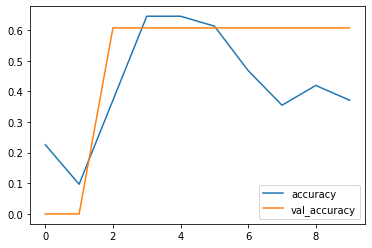

In [37]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

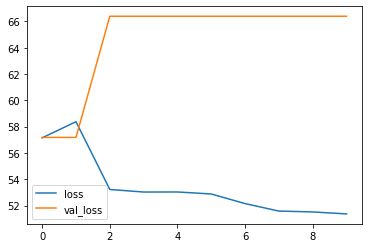

In [38]:
history_df.loc[:, ['loss', 'val_loss']].plot()

Test LSTM

In [42]:
lstm_model = keras.Sequential([
    layers.Dense(32,input_shape=(20,13), activation='relu'),
    layers.LSTM(128),
    layers.Dense(1, activation='linear')
])

In [43]:
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

In [44]:
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_split=0.3)

Epoch 1/20
2/2 - 4s - loss: 40.4161 - accuracy: 0.6452 - val_loss: 60.4555 - val_accuracy: 0.6071 - 4s/epoch - 2s/step
Epoch 2/20
2/2 - 0s - loss: 30.7184 - accuracy: 0.6452 - val_loss: 14.8860 - val_accuracy: 0.6071 - 152ms/epoch - 76ms/step
Epoch 3/20
2/2 - 0s - loss: 12.9856 - accuracy: 0.6452 - val_loss: 11.7683 - val_accuracy: 0.6071 - 107ms/epoch - 54ms/step
Epoch 4/20
2/2 - 0s - loss: 10.3741 - accuracy: 0.6452 - val_loss: 9.8314 - val_accuracy: 0.6071 - 70ms/epoch - 35ms/step
Epoch 5/20
2/2 - 0s - loss: 8.6974 - accuracy: 0.6452 - val_loss: 8.4407 - val_accuracy: 0.6071 - 85ms/epoch - 43ms/step
Epoch 6/20
2/2 - 0s - loss: 7.5427 - accuracy: 0.6452 - val_loss: 7.3518 - val_accuracy: 0.6071 - 81ms/epoch - 41ms/step
Epoch 7/20
2/2 - 0s - loss: 6.5833 - accuracy: 0.6452 - val_loss: 6.4628 - val_accuracy: 0.6071 - 72ms/epoch - 36ms/step
Epoch 8/20
2/2 - 0s - loss: 6.8925 - accuracy: 0.6452 - val_loss: 7.3355 - val_accuracy: 0.6071 - 79ms/epoch - 40ms/step
Epoch 9/20
2/2 - 0s - loss:

Mélange SimpleRNN et LSTM

In [55]:
lstm_rnn_model = keras.Sequential([
    layers.Dense(32,input_shape=(20,13), activation='linear'),
    layers.LSTM(128, return_sequences=True, activation='linear'), # return_sequences à True pour que la sortie soit de dimension 3
    layers.SimpleRNN(64,activation='linear'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')
])

opt = keras.optimizers.SGD(learning_rate=0.1)
lstm_rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

In [56]:
history = lstm_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.3)

Epoch 1/50
2/2 - 4s - loss: 41.9468 - accuracy: 0.5323 - val_loss: 51.9281 - val_accuracy: 0.5714 - 4s/epoch - 2s/step
Epoch 2/50
2/2 - 0s - loss: 35.5152 - accuracy: 0.5484 - val_loss: 51.9281 - val_accuracy: 0.5714 - 106ms/epoch - 53ms/step
Epoch 3/50
2/2 - 0s - loss: 53.5804 - accuracy: 0.5806 - val_loss: 51.9281 - val_accuracy: 0.5714 - 107ms/epoch - 54ms/step
Epoch 4/50
2/2 - 0s - loss: 36.2530 - accuracy: 0.5000 - val_loss: 51.9281 - val_accuracy: 0.5714 - 97ms/epoch - 49ms/step
Epoch 5/50
2/2 - 0s - loss: 35.0232 - accuracy: 0.5806 - val_loss: 51.9281 - val_accuracy: 0.5714 - 98ms/epoch - 49ms/step
Epoch 6/50
2/2 - 0s - loss: 60.7500 - accuracy: 0.5161 - val_loss: 51.9281 - val_accuracy: 0.5714 - 229ms/epoch - 114ms/step
Epoch 7/50
2/2 - 0s - loss: 29.5754 - accuracy: 0.5323 - val_loss: 51.9281 - val_accuracy: 0.5714 - 217ms/epoch - 109ms/step
Epoch 8/50
2/2 - 0s - loss: 10.5263 - accuracy: 0.5645 - val_loss: 51.9281 - val_accuracy: 0.5714 - 153ms/epoch - 77ms/step
Epoch 9/50
2/

<AxesSubplot:>

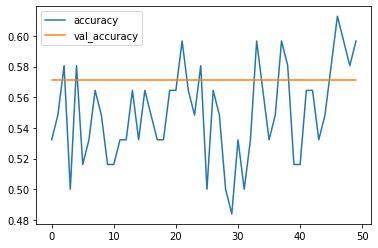

In [57]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

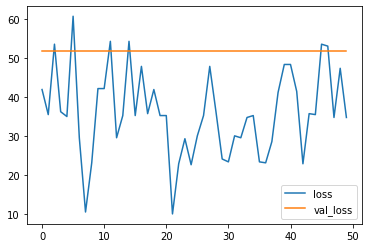

In [58]:
history_df.loc[:, ['loss', 'val_loss']].plot()